In [3]:
import sys
from dataclasses import dataclass
from enum import Enum, auto
import copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import mplhep as hep
plt.style.use(hep.style.CMS)
import hist

sys.path.append("../..")
from HistogramLib.histogram import HistogramKind
from HistogramLib.store import HistogramStore
from hists.parameters import beamEnergies
from hists.store import HistogramId

In [4]:
hist_folder = '/grid_mnt/data_cms_upgrade/cuisset/testbeam18/clue3d/v28'
#clueParams = "single-file"
clueParams = "cmssw"
histStore = HistogramStore(hist_folder, HistogramId)
datatypeToLegendMap = {"data":"Data"}

In [5]:
h:hist.Hist=(histStore
        .get(HistogramId("RechitsEnergyReconstructedPerLayer", clueParams, "data"))
        .getHistogram(HistogramKind.PROFILE)
    )[{"beamEnergy":hist.loc(20)}]
h[1]

Mean(count=19969, value=0.328024, variance=0.0519157)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f513be2e2d0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

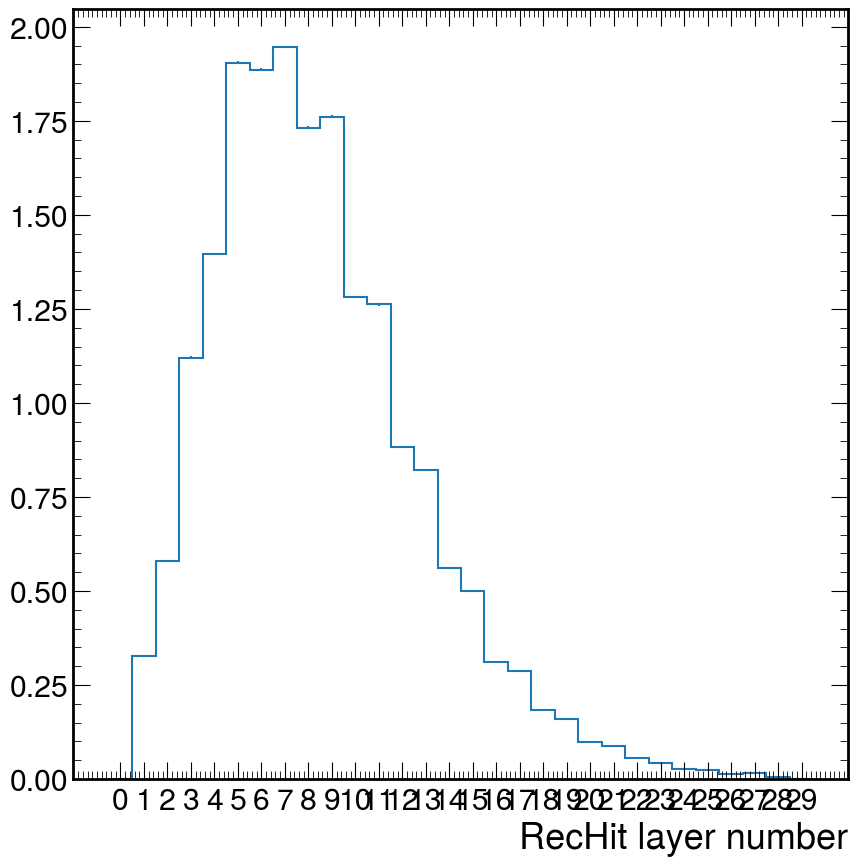

In [6]:
h.plot()

In [7]:
def buildCumulativeDistribution(h:hist.Hist):
    """ Build a cumulative energy distribution per layer, from a distribution of energy per layer
    Param : h : a profile histogram of mean reconstructed energy per layer
    Returns a count histogram, but with mean values (should be plotted with yerr=False to avoid huge error bars) """
    cumul = hist.Hist(h.axes[0])
    cumul[-1] = 0
    for i in range(h.axes[0].size):
        cumul[i] = cumul[i-1] + h[i].value
    return cumul

In [8]:
def makeCumulativeDistribution(datatypes:list[str], beamEnergy:int):
    hists = [buildCumulativeDistribution(
            (histStore
                .get(HistogramId("RechitsEnergyReconstructedPerLayer", clueParams, datatype))
                .getHistogram(HistogramKind.PROFILE)
            )[
                {"beamEnergy":hist.loc(beamEnergy)}
            ]
        ) for datatype in datatypes]

    plt.figure()
    plt.xlabel("Layer")
    plt.ylabel("Cumulative energy distribution (profile) (GeV)")
    
    hep.histplot(hists, yerr=False, label=datatypes)

    plt.xlim(1, 28)
    if "data" in datatypes:
        hep.cms.text("Preliminary")
    else:
        hep.cms.text("Simulation Preliminary")
    hep.cms.lumitext("$e^+$ " + str(beamEnergy) + " GeV")
    plt.legend()

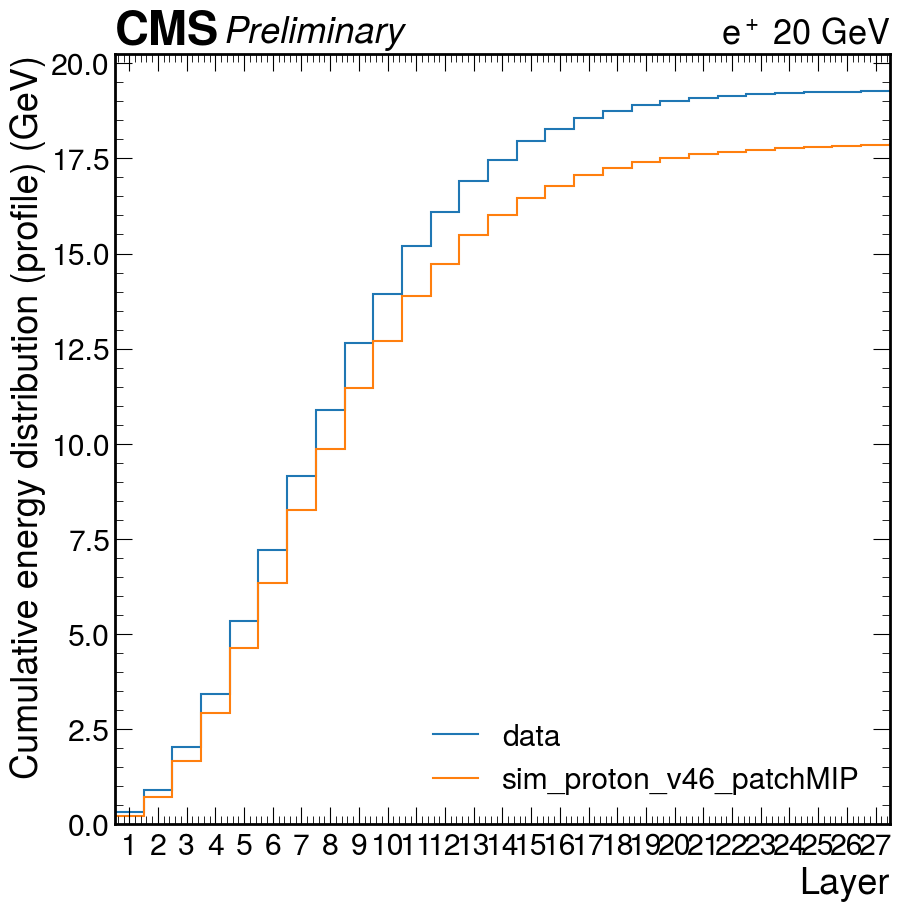

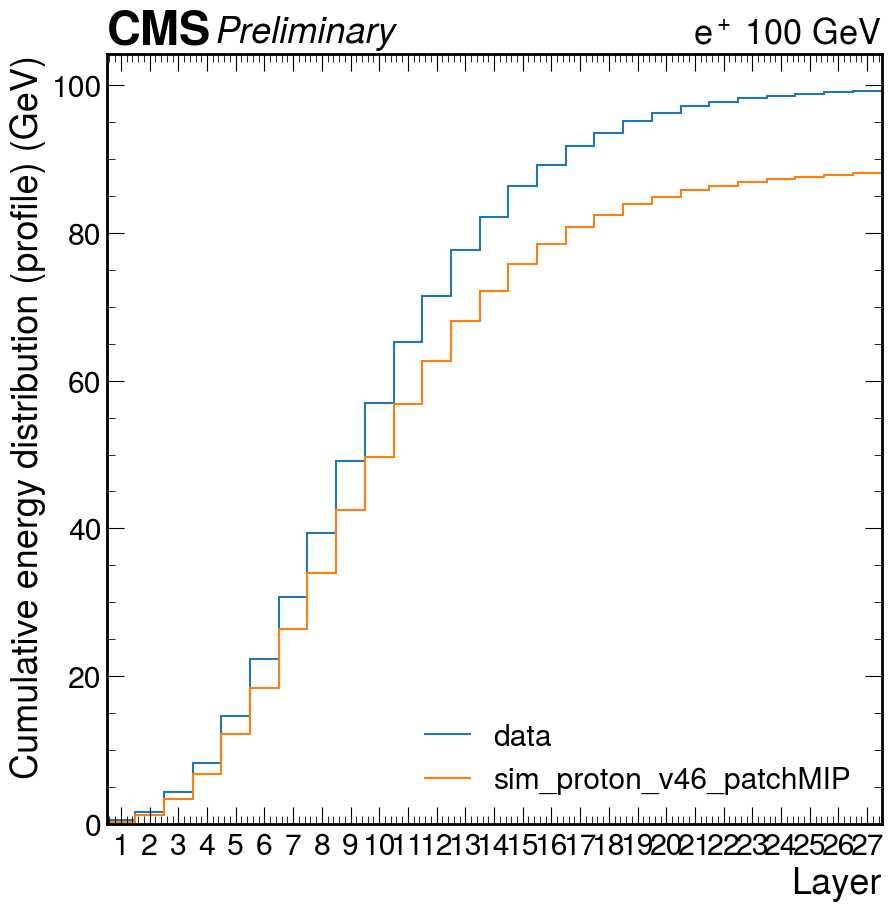

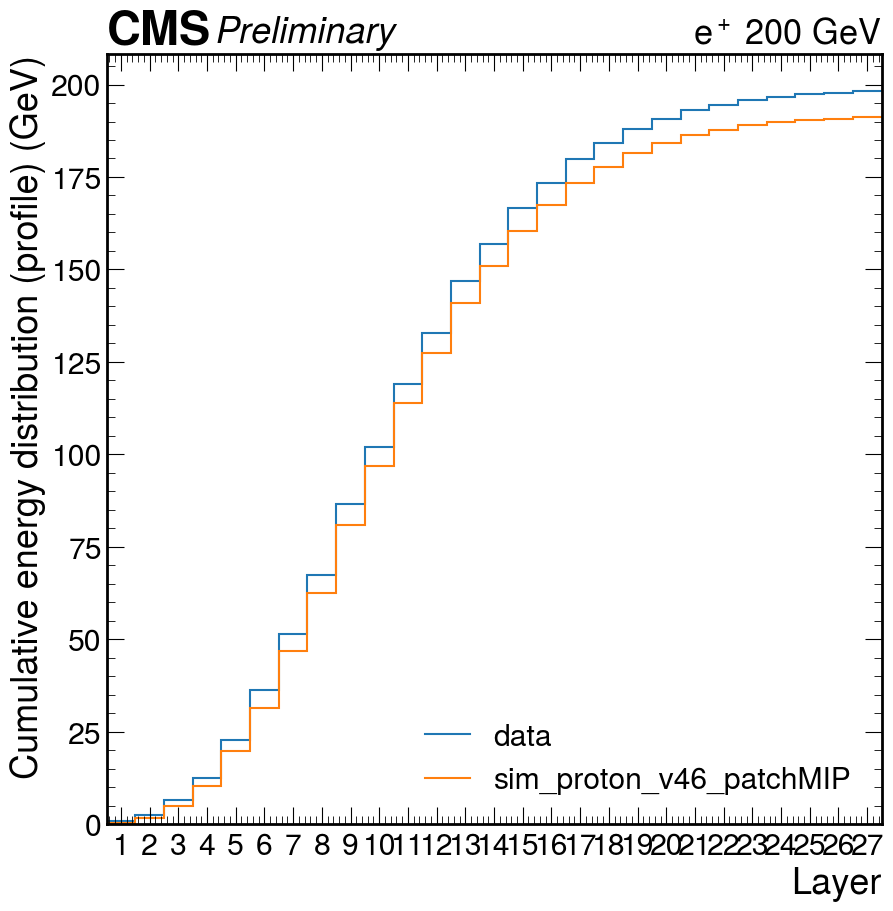

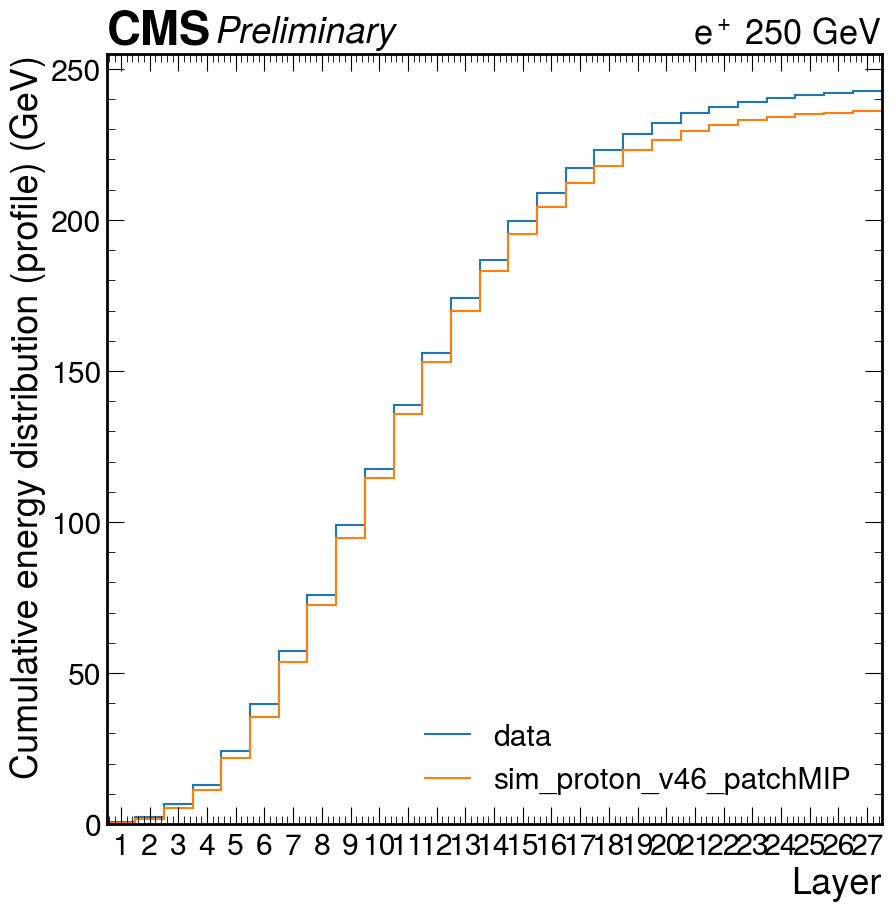

In [9]:
makeCumulativeDistribution(["data", "sim_proton_v46_patchMIP"], 20)
makeCumulativeDistribution(["data", "sim_proton_v46_patchMIP"], 100)
makeCumulativeDistribution(["data", "sim_proton_v46_patchMIP"], 200)
makeCumulativeDistribution(["data", "sim_proton_v46_patchMIP"], 250)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f5138c54490>, errorbar=None, legend_artist=None)]

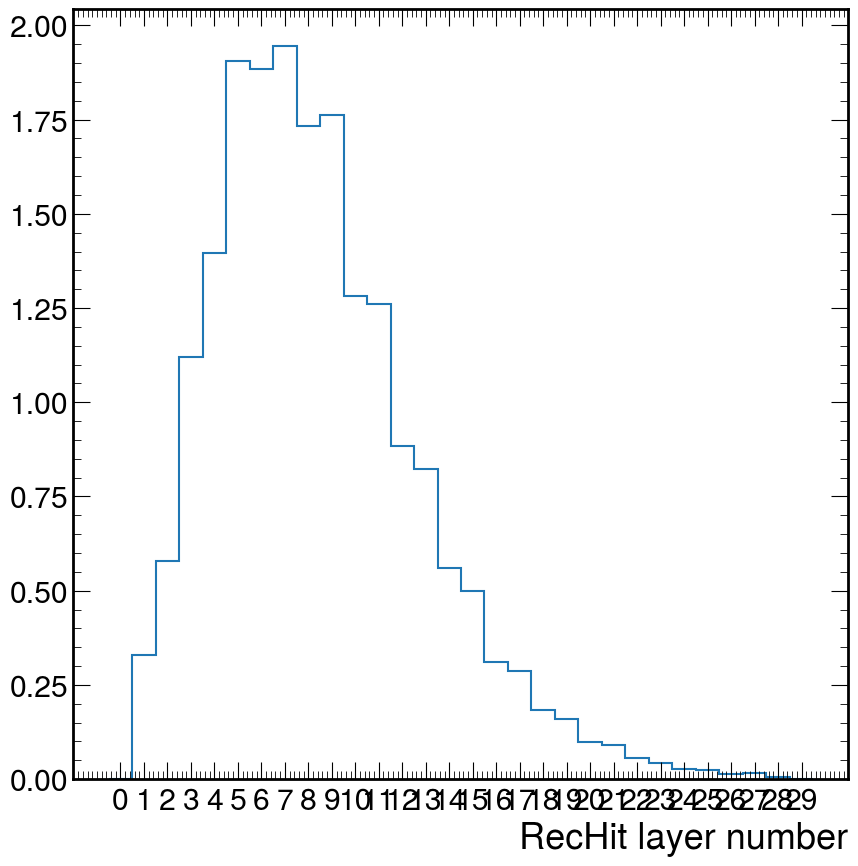

In [10]:
hep.histplot(h, yerr=False)

In [24]:
def makeCumulativeDistributionRatio(datatypes:tuple[str], beamEnergy:int):
    hists = [buildCumulativeDistribution(
            (histStore
                .get(HistogramId("RechitsEnergyReconstructedPerLayer", clueParams, datatype))
                .getHistogram(HistogramKind.PROFILE)
            )[
                {"beamEnergy":hist.loc(beamEnergy)}
            ]
        ) for datatype in datatypes]
    
    fig = plt.figure()
    grid = fig.add_gridspec(2, 1, hspace=0, height_ratios=[3, 1])

    main_ax:plt.Axes = fig.add_subplot(grid[0])
    
    subplot_ax:plt.Axes = fig.add_subplot(grid[1], sharex=main_ax)
    plt.setp(main_ax.get_xticklabels(), visible=False)
    for ax in (main_ax, subplot_ax):
        ax.xaxis.set_minor_locator(matplotlib.ticker.NullLocator())
        

    self_artists = hep.histplot(hists[0], ax=main_ax, yerr=False, label=datatypes[0])
    other_artists = hep.histplot(hists[1], ax=main_ax, yerr=False, label=datatypes[1])

    main_ax.set_ylabel("Mean energy reconstructed\nper layer (GeV)")
    main_ax.legend()
    
    for label in subplot_ax.xaxis.get_ticklabels()[1::2]:
        label.set_visible(False)

    with np.errstate(divide="ignore", invalid="ignore"):
        ratios = hists[0].values() / hists[1].values()
        hist.plot.plot_ratio_array(hists[0], ratios, None, subplot_ax, ylim=(0.5,1.8), ylabel="Ratio")

    if "data" in datatypes:
        hep.cms.text("Preliminary", ax=main_ax)
    else:
        hep.cms.text("Simulation Preliminary", ax=main_ax)
    hep.cms.lumitext(f"TB $e^+$ {beamEnergy} GeV", ax=main_ax)

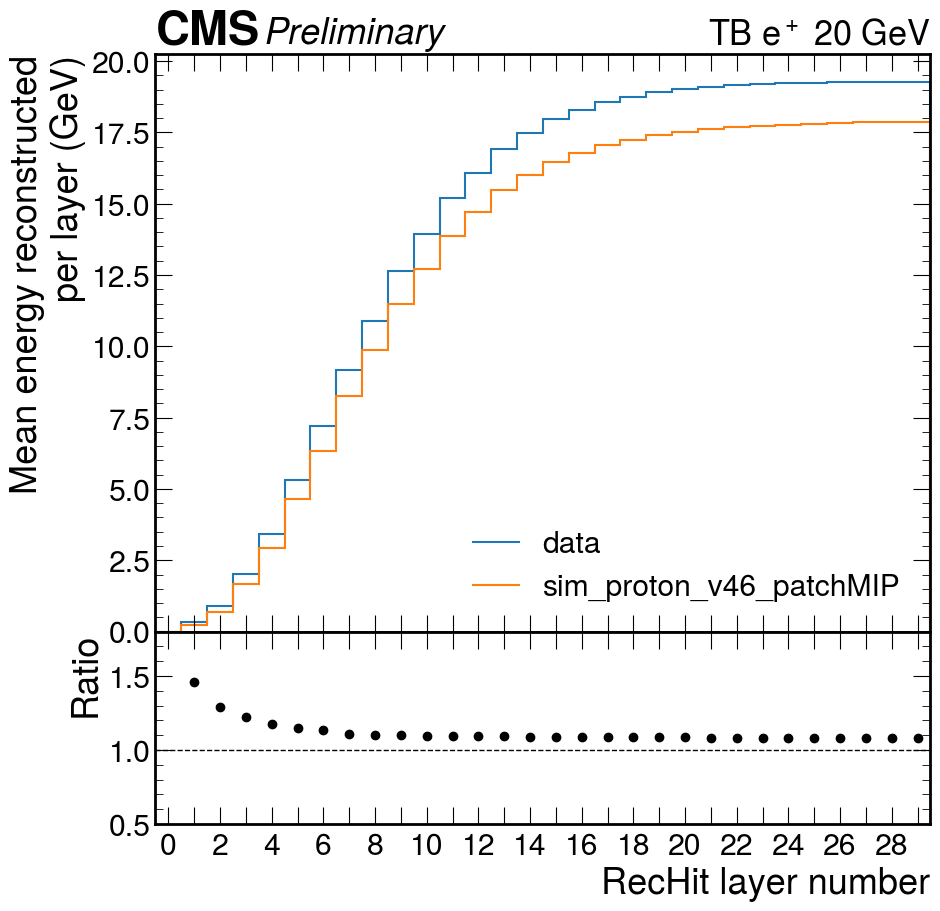

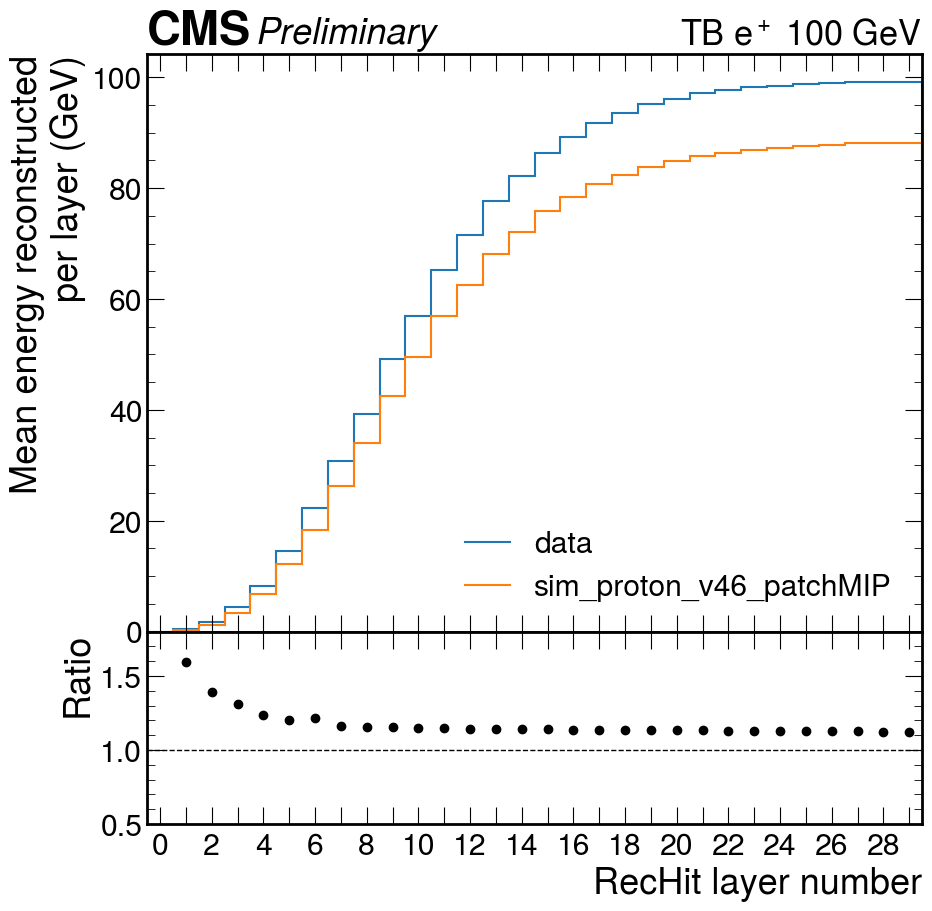

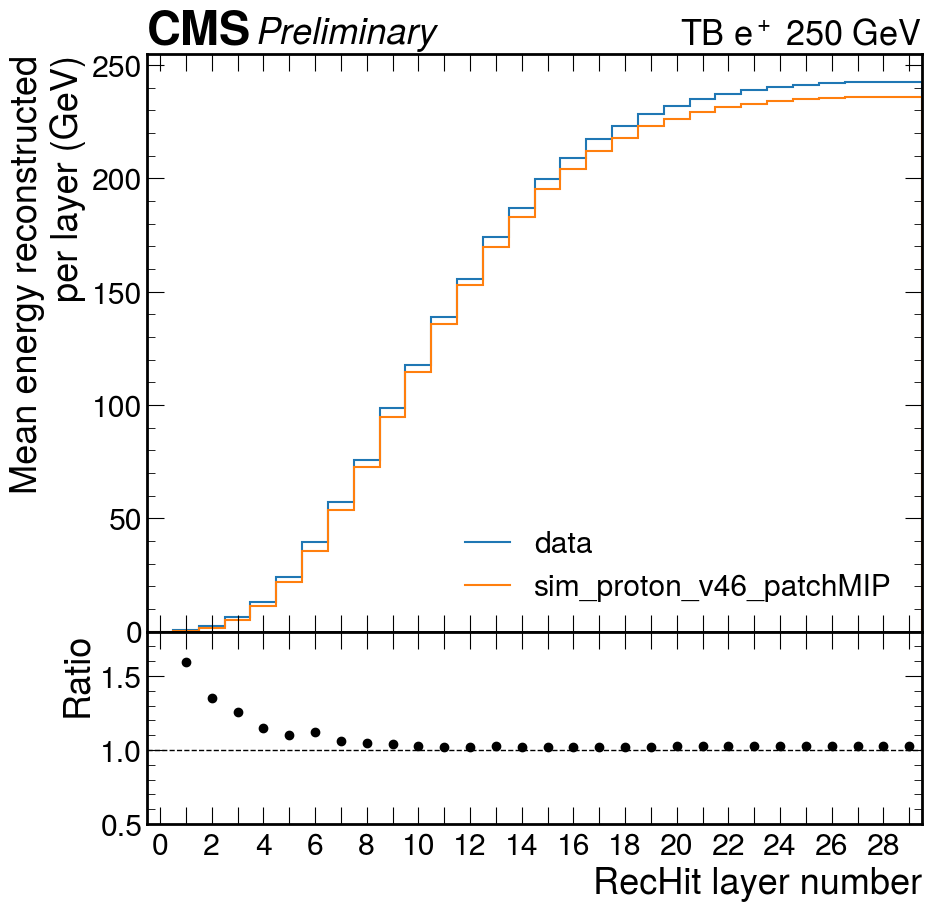

In [25]:
makeCumulativeDistributionRatio(["data", "sim_proton_v46_patchMIP"], 20)
makeCumulativeDistributionRatio(["data", "sim_proton_v46_patchMIP"], 100)
makeCumulativeDistributionRatio(["data", "sim_proton_v46_patchMIP"], 250)